This notebook contains all the code necessary to run the article's Fig. 3.

A python file version of this notebook can be found in the code folder.

Importing relevant modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
import os 
%matplotlib inline

# Change directory to the code folder
os.chdir('..//code')

# Functions to sample the diffusion-weighted gradient directions
from dipy.core.sphere import disperse_charges, HemiSphere

# Function to reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# Functions to perform simulations based on multi-compartment models
from dipy.sims.voxel import multi_tensor

# Import Dipy's procedures to process diffusion tensor
import dipy.reconst.dti as dti

# Importing procedures to fit the free water elimination DTI model
from functions import nls_fit_tensor

Defining the acquisition parameters...

In [2]:
# Number of parameter acquisition sets tested
nacq = 6

# Defining a vector containing the number of shells for each
# tested acquisition
n_shells = np.array([2, 3, 4, 6, 8, 16])

# Defining matrix containing the b-values for each tested
# acquisition at each row.
bval_matrix = np.zeros((nacq, 16))
bval_matrix[0, 0:2] = [500, 1500]
bval_matrix[1, 0:3] = [500, 1000, 1500]
bval_matrix[2, 0:4] = [400, 767, 1133, 1500]
bval_matrix[3, 0:6] = [400, 620, 840, 1060, 1280, 1500]
bval_matrix[4, 0:8] = [300, 471, 643, 814, 986, 1157, 1329,
                       1500]
bval_matrix[5, 0:16] = [300, 380, 460, 540, 620, 700, 780,
                        860, 940, 1020, 1100, 1180, 1260,
                        1340, 1420, 1500]

# Defining matrix containing the number of gradient diretion
# for each tested acquisition at each row.
pts_matrix = np.zeros((nacq, 16))
pts_matrix[0, 0:2] = 32
pts_matrix[1, 0:3] = [21, 21, 22]
pts_matrix[2, 0:4] = 16
pts_matrix[3, 0:6] = [10, 10, 10, 10, 10, 14]
pts_matrix[4, 0:8] = 8
pts_matrix[5, 0:16] = 4

# Sampled the directions for all shells of all 6 tested
# acquisition parameter sets. Parameters are saved in
# full_bvecs (nacq x total number of gradient directions x 3)
# and full_bvals (nacq x total number of gradient directions)

# Initialization full_bvals and full_bvecs
full_bvecs = np.zeros((nacq, 70, 3))
full_bvals = np.zeros((nacq, 70))

# Reconstruction full_bvecs and full_bvals
for acq_i in range(nacq):

    # 1) Initialize acquisition parameters for 6 first
    # b-value = 0
    bvecs = np.zeros((6, 3))
    bvals = np.zeros(6)
    
    # 2) Add b-values and gradient directions for the
    # other acquisition shells
    for shell_i in range(n_shells[acq_i]):
        
        # Sample the evenly distributed directions given
        # the number of direction of the shell
        n_pts = pts_matrix[acq_i, shell_i]
        theta = np.pi * np.random.rand(n_pts)
        phi = 2 * np.pi * np.random.rand(n_pts)
        hsph_initial = HemiSphere(theta=theta, phi=phi)
        hsph_updated, potential = disperse_charges(hsph_initial,
                                                   5000)
        directions = hsph_updated.vertices

        # Add directions to bvecs
        bvecs = np.vstack((bvecs, directions))
        
        # Add b-values to bvals according to the number of
        # shell directions
        b = bval_matrix[acq_i, shell_i]
        bvals = np.hstack((bvals, b * np.ones(n_pts)))
    full_bvecs[acq_i, :, :] = bvecs
    full_bvals[acq_i, :] = bvals
    
    # Display progress    
    prog = (acq_i+1.0) / nacq * 100
    time.sleep(1)
    sys.stdout.write("\r%f%%" % prog)
    sys.stdout.flush()

# Defining vector containing SNR tested
SNR = np.array([20, 30, 40, 50, 60])

100.000000%

Defining the ground truth values for multi-compartmental simulations

In [3]:
# Free water volume fraction is set to 50% according to
# Hoy et al. (2014)
VF = 50

# The value of free water diffusion is set to its known value 
Dwater = 3e-3

# Simulations are repeated for high and low FA values
FA = np.array([0.71, 0.])
L1 = np.array([1.6e-3, 0.8e-03])
L2 = np.array([0.5e-3, 0.8e-03])
L3 = np.array([0.3e-3, 0.8e-03])
TRACE = 2.4e-3

# According to Hoy et al., simulations are repeated for 120 different
# diffusion tensor directions (and each direction repeated 100 times).
nDTdirs = 120
nrep = 100

# These directions are sampled using the same procedure used
# to evenly sample the diffusion gradient directions
theta = np.pi * np.random.rand(nDTdirs)
phi = 2 * np.pi * np.random.rand(nDTdirs)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
DTdirs = hsph_updated.vertices

Generating simulations

In [4]:
# Initializing a matrix to save fwDTI fitting results
# for all acquisition parameters and SNR levels.
# Each dimension of this matrix corresponds to the
# number of acquisition parameters sets, number of
# simulated FA levels, SNR levels, simulations
# repetitions, and diffusion-weighted signals
fw_params = np.empty((nacq, FA.size, SNR.size,
                      nrep * nDTdirs, 13))

# estimating volume fractions for both simulations
# compartments
fracts = [100 - VF, VF]

# Run simulations for all 6 acquisition parameter sets
for acq_i in range(6):

    # Convert acquisition parameter set in dipy's format:
    gtab = gradient_table(full_bvals[acq_i], full_bvecs[acq_i])

    # Initialize matrix that saves all multi-compartmental
    # simulations for the given acquisition parameter sets
    DWI_simulates = np.empty((FA.size, SNR.size,
                              nrep * nDTdirs, 70))
    # Simulations are performed for the given fa levels
    for fa_i in range(FA.size):

        # selecting the diffusion eigenvalues for a given FA level
        mevals = np.array([[L1[fa_i], L2[fa_i], L3[fa_i]],
                           [Dwater, Dwater, Dwater]])

        # Simulations are performed for the given SNR levels
        for snr_i in range(SNR.size):

            # select a given snr
            snr = SNR[snr_i]

            # Simulations are performed for 120 Diffusion tensor
            # directions
            for di in range(nDTdirs):
                # Select a diffusion tensor direction
                d = DTdirs[di]

                # Repeat simulations for the given directions
                for s_i in np.arange(di * nrep, (di+1) * nrep):
                    # Multi-compartmental simulations using
                    # Dipy's function multi_tensor
                    signal, sticks = multi_tensor(gtab, mevals,
                                                  S0=100,
                                                  angles=[d, (1, 0, 0)],
                                                  fractions=fracts,
                                                  snr=snr)
                    DWI_simulates[fa_i, snr_i, s_i, :] = signal

    # Fit all simulated signals for given set of parameters
    params = nls_fit_tensor(gtab, DWI_simulates, Diso=Dwater)
    fw_params[acq_i, ...] = params

    # Display progress    
    prog = (acq_i+1.0) / nacq * 100
    time.sleep(1)
    sys.stdout.write("\r%f%%" % prog)
    sys.stdout.flush()

100.000000%

Compute and plot MSE for both high and low FA level and for all acquisition parameter sets and SNRs. MSE are plotted for each as a function of SNR

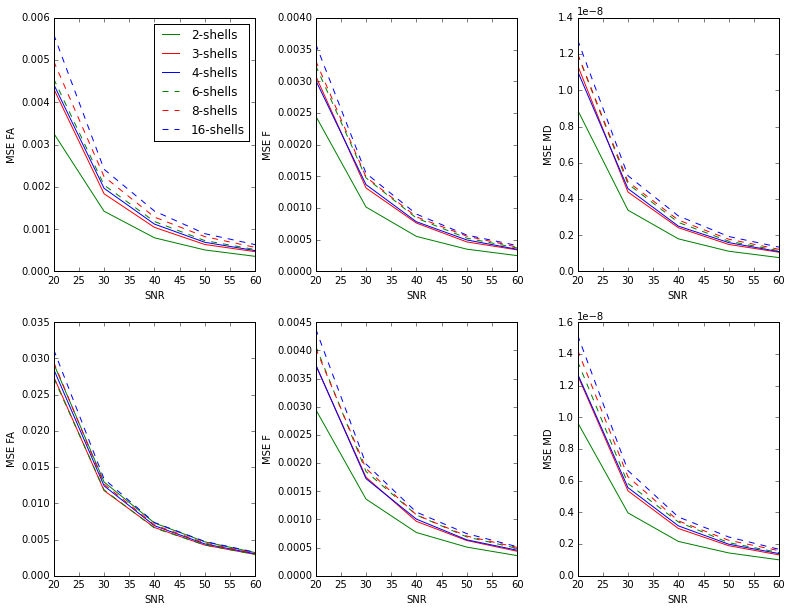

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(13, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.3)

# Defining the figure's acquisition labels
# colors and line styles
colors = {0: 'g', 1: 'r', 2: 'b', 
          3: 'g', 4: 'r', 5: 'b'}
lstyle = {0: '-', 1: '-', 2: '-', 
          3: '--', 4: '--', 5: '--'}
acquisition = {0: '2-shells',
               1: '3-shells',
               2: '4-shells',
               3: '6-shells',
               4: '8-shells',
               5: '16-shells'}

# For both FA level
for fa_i in range(2):

    # compute mse values for all acquisitions
    for acq_i in range(nacq):
        
        # initialize mse vector for each fwDTI measure
        msef = np.zeros(SNR.shape)
        msefa = np.zeros(SNR.shape)
        msemd = np.zeros(SNR.shape)
    
        for snr_i in range(SNR.size):
            # select diffusion eigenvalues
            evals = fw_params[acq_i, fa_i, snr_i, :, :3]

            # Compute the tissue's diffusion tensor FA
            # using Dipy's module dti
            fa = dti.fractional_anisotropy(evals)

            # select computed water volume fraction
            f = fw_params[acq_i, fa_i, snr_i, :, 12]

            # Compute diffusion tensor md
            md = np.sum(evals, axis=-1) / 3.0

            # Compute the squared differences
            df2 = np.square(f - VF*0.01)
            dfa2 = np.square(fa - FA[fa_i])
            dmd2 = np.square(md - TRACE/3.0)

            # Compute the mean squared error
            ntrep = nrep*nDTdirs
            msef[snr_i] = np.sum(df2.ravel()) / ntrep
            msefa[snr_i] = np.sum(dfa2.ravel()) / ntrep
            msemd[snr_i] = np.sum(dmd2.ravel()) / ntrep

        # Plot FA mse as a function of the SNR
        axs[fa_i, 0].plot(SNR, msefa, ls=lstyle[acq_i],
                          color=colors[acq_i],
                          linewidth=1.0,
                          label=acquisition[acq_i])
        axs[fa_i, 0].set_xlabel('SNR')
        axs[fa_i, 0].set_ylabel('MSE FA')

        # Plot F mse as a function of the SNR
        axs[fa_i, 1].plot(SNR, msef, ls=lstyle[acq_i],
                          color=colors[acq_i],
                          linewidth=1.0,
                          label=acquisition[acq_i])
        axs[fa_i, 1].set_xlabel('SNR')
        axs[fa_i, 1].set_ylabel('MSE F')

        # Plot Trace mse as a function of the SNR
        axs[fa_i, 2].plot(SNR, msemd, ls=lstyle[acq_i],
                          color=colors[acq_i],
                          linewidth=1.0,
                          label=acquisition[acq_i])
        axs[fa_i, 2].set_xlabel('SNR')
        axs[fa_i, 2].set_ylabel('MSE MD')


# Set legend in upper left panel
axs[0, 0].legend(loc='upper right')

# Save figure
fig.savefig('fwdti_simulations_3.png', bbox_inches='tight')

Done